In [3]:
import numpy as np
import pandas as pd
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('emnist-balanced-train.csv', header=None)
test = pd.read_csv('emnist-balanced-test.csv', header=None)
train.head()


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,45,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Now split labels and images from original dataframe.
train_data = train.iloc[:, 1:]
train_labels = train.iloc[:, 0]
test_data = test.iloc[:, 1:]
test_labels = test.iloc[:, 0]
# one hot 
train_labels = pd.get_dummies(train_labels)
test_labels = pd.get_dummies(test_labels)
train_labels.head()

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


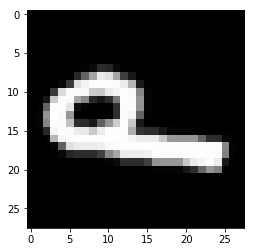

In [4]:
# Turn our Dataframes into numpy array and delete train and test to save up memory.
train_data = train_data.values
train_labels = train_labels.values
test_data = test_data.values
test_labels = test_labels.values
del train, test
# For some reason, sadly, the EMNIST dataset was rotated and flipped and we need fix that.
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(train_data[45].reshape([28, 28]), cmap='Greys_r')
plt.show()


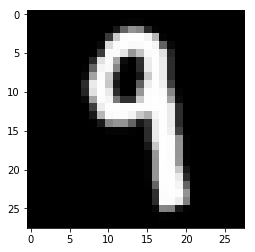

In [5]:
def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image.reshape([28,28,1])
    
train_data = np.apply_along_axis(rotate, 1, train_data)/255
test_data = np.apply_along_axis(rotate, 1, test_data)/255



plt.imshow(train_data[45].reshape([28, 28]), cmap='Greys_r')
plt.show()



In [6]:
from keras.utils import np_utils
from keras.layers import Input, Dense, Dropout, Reshape,Conv2D,Flatten,MaxPooling2D
from keras.models import Model,load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [7]:
num_classes = 47
inp = Input(shape=(28,28,1))
#rel_input = Reshape((28,28,1))(inp)
c1 = Conv2D(8, (3, 3), activation='relu')(inp)
c1 = Dropout(0.2)(c1)
c1 = Conv2D(16, (3, 3), activation='relu')(c1)
c1 = MaxPooling2D(pool_size=(2, 2))(c1)
c2 = Conv2D(32, (3, 3), activation='relu',padding="same")(c1)
c2 = Dropout(0.2)(c2)
c2 = Conv2D(32, (3, 3), activation='relu',padding="same")(c2)
c2 = MaxPooling2D(pool_size=(2, 2))(c2)
c3 = Conv2D(64, (3, 3), activation='relu',padding="same")(c2)
c3 = MaxPooling2D(pool_size=(2, 2))(c3)
f = Flatten()(c3)
f = Dropout(0.3)(f)
h1 = Dense(100, activation='relu')(f) 
h1 = Dropout(0.3)(h1)
out = Dense(num_classes, activation='softmax')(h1) 
model = Model(input=inp, output=out)

model.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 8)         80        
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 26, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 32)        4640      
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 32)        0         
__________

/anaconda3/envs/demo/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


# training 

In [8]:
from keras.utils import multi_gpu_model

parallel_model = multi_gpu_model(model, gpus=4)

parallel_model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer='adam', # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy

reduce_lr = ReduceLROnPlateau(factor=0.33, patience=3, min_lr=0.00001, verbose=1)
checkpointer = ModelCheckpoint('model-emnist-nn0.h5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(patience=8, verbose=1)

history=parallel_model.fit(train_data, train_labels, # Train the model using the training set...
          batch_size=128, nb_epoch=50,
          verbose=1, validation_split=0.1,callbacks=[earlystopper,checkpointer,reduce_lr]) # ...holding out 10% of the data for validation




/home/feng/.conda/envs/test/lib/python3.6/site-packages/ipykernel/__main__.py:15: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 101520 samples, validate on 11280 samples
Epoch 1/50
101520/101520 [==============================] - 8s 80us/step - loss: 1.3157 - acc: 0.6098 - val_loss: 0.5031 - val_acc: 0.8243

Epoch 00001: val_loss improved from inf to 0.50307, saving model to model-emnist-nn0.h5
Epoch 2/50
101520/101520 [==============================] - 5s 52us/step - loss: 0.6143 - acc: 0.7951 - val_loss: 0.4144 - val_acc: 0.8512

Epoch 00002: val_loss improved from 0.50307 to 0.41439, saving model to model-emnist-nn0.h5
Epoch 3/50
101520/101520 [==============================] - 5s 51us/step - loss: 0.5196 - acc: 0.8241 - val_loss: 0.3746 - val_acc: 0.8645

Epoch 00003: val_loss improved from 0.41439 to 0.37461, saving model to model-emnist-nn0.h5
Epoch 4/50
101520/101520 [==============================] - 5s 51us/step - loss: 0.4786 - acc: 0.8358 - val_loss: 0.3551 - val_acc: 0.8702

Epoch 00004: val_loss improved from 0.37461 to 0.35513, saving model to model-emnist-nn0.h5
Epoch 5/50
101520/101520 

101520/101520 [==============================] - 5s 51us/step - loss: 0.2773 - acc: 0.8955 - val_loss: 0.2876 - val_acc: 0.8906

Epoch 00038: val_loss did not improve from 0.28674
Epoch 39/50
101520/101520 [==============================] - 5s 50us/step - loss: 0.2784 - acc: 0.8944 - val_loss: 0.2878 - val_acc: 0.8909

Epoch 00039: val_loss did not improve from 0.28674
Epoch 40/50
101520/101520 [==============================] - 5s 50us/step - loss: 0.2778 - acc: 0.8953 - val_loss: 0.2896 - val_acc: 0.8902

Epoch 00040: val_loss did not improve from 0.28674

Epoch 00040: ReduceLROnPlateau reducing learning rate to 3.5936999920522795e-05.
Epoch 41/50
101520/101520 [==============================] - 5s 51us/step - loss: 0.2752 - acc: 0.8965 - val_loss: 0.2878 - val_acc: 0.8908

Epoch 00041: val_loss did not improve from 0.28674
Epoch 42/50
101520/101520 [==============================] - 5s 50us/step - loss: 0.2746 - acc: 0.8966 - val_loss: 0.2876 - val_acc: 0.8912

Epoch 00042: val_loss

# with agumentation

In [18]:
datagen = ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    #shear_range = 0.05,
    horizontal_flip=False)

datagen.fit(train_data)

# fits the model on batches with real-time data augmentation:
parallel_model.fit_generator(datagen.flow(train_data[:10000], train_labels[:10000],batch_size=128), 
                             steps_per_epoch=len(train_data) / 128, epochs = 50,
          verbose=1, validation_data=(train_data[10000:], train_labels[10000:]),callbacks=[earlystopper,checkpointer,reduce_lr])


print(parallel_model.evaluate(test_data, test_labels, verbose=1)) # Evaluate the trained model on the test set!


Epoch 1/50
882/881 [==============================] - 19s 21ms/step - loss: 1.4976 - acc: 0.5582 - val_loss: 0.5047 - val_acc: 0.8296

Epoch 00001: val_loss improved from inf to 0.50467, saving model to model-emnist-nn.h5
Epoch 2/50
882/881 [==============================] - 18s 20ms/step - loss: 0.6800 - acc: 0.7705 - val_loss: 0.4256 - val_acc: 0.8500

Epoch 00002: val_loss improved from 0.50467 to 0.42561, saving model to model-emnist-nn.h5
Epoch 3/50
882/881 [==============================] - 18s 20ms/step - loss: 0.5493 - acc: 0.8091 - val_loss: 0.4009 - val_acc: 0.8595

Epoch 00003: val_loss improved from 0.42561 to 0.40095, saving model to model-emnist-nn.h5
Epoch 4/50
882/881 [==============================] - 18s 20ms/step - loss: 0.4882 - acc: 0.8272 - val_loss: 0.3922 - val_acc: 0.8612

Epoch 00004: val_loss improved from 0.40095 to 0.39222, saving model to model-emnist-nn.h5
Epoch 5/50
882/881 [==============================] - 18s 20ms/step - loss: 0.4512 - acc: 0.8376 - v

In [8]:
model=load_model('model-emnist-nn0.h5')

# evaluation

In [9]:
model.evaluate(train_data[-11280:],train_labels[-11280:])

11280/11280 [==============================] - 4s 353us/step


[0.28639825538117836, 0.8908687943262411]

# error analyze

In [14]:
id_name = {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',
        8:'8',9:'9',10 :"A",11 :"B",12 :"C",13 :"D",14 :"E",15 :"F",
        16 :"G",17 :"H",18 :"I",19 :"J",20 :"K",21 :"L",22 :"M",
        23 :"N",24 :"O",25 :"P",26 :"Q",27 :"R",28 :"S",29 :"T",
        30 :"U",31 :"V",32 :"W",33 :"X",34 :"Y",35 :"Z",36 :"a",
        37:"b",38:"d",39:"e",40:"f",41:"g",42:"h",43:"n",44:"q",
        45:"r",46:"t"
}

In [10]:
len(train_labels)*0.9

101520.0

In [11]:
prediction = model.predict(train_data[101520:])

In [12]:
for i in range(101520,101520+1000):
    if np.argmax(prediction[i-101520])!=np.argmax(train_labels[i]):
        print(i)

101534
101544
101545
101549
101556
101568
101572
101597
101599
101602
101605
101608
101609
101634
101637
101640
101649
101653
101654
101656
101666
101672
101701
101702
101704
101712
101724
101735
101742
101743
101745
101760
101765
101784
101788
101805
101817
101842
101851
101853
101857
101871
101879
101887
101891
101898
101907
101916
101928
101931
101932
101936
101941
101944
101952
101983
101996
101997
102008
102009
102010
102022
102023
102025
102031
102039
102046
102050
102051
102056
102064
102065
102068
102073
102074
102095
102102
102103
102106
102108
102111
102113
102121
102129
102141
102153
102159
102164
102176
102183
102209
102217
102235
102238
102254
102259
102262
102268
102283
102287
102309
102310
102319
102328
102337
102345
102350
102357
102372
102373
102377
102387
102400
102402
102408
102415
102438
102442
102447
102448
102468
102476
102479
102497
102501
102509
102515
102517


Label: F
pre： F


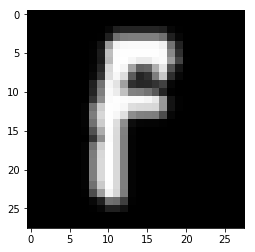

In [15]:
idx = 101830
plt.imshow(train_data[idx][:,:,0],cmap='gray')
print("Label:",id_name[np.argmax(train_labels[idx])])
print("pre：",id_name[np.argmax(prediction[idx-101520])])

1


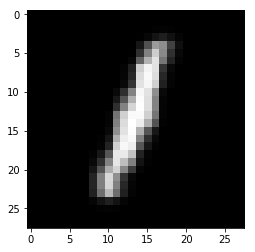

In [16]:
idx = 9
plt.imshow(train_data[idx][:,:,0],cmap='gray')
print(id_name[np.argmax(train_labels[idx])])
#print(np.argmax(train_labels[idx])-10)

In [1]:
tmp = plt.imread("./real/j.png")[:,:,0]
plt.imshow(1.0*(tmp<0.5), cmap='gray')

NameError: name 'plt' is not defined

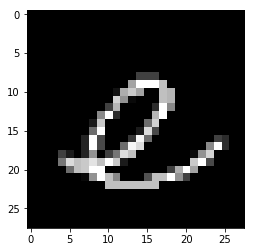

In [24]:
txtt = 1.0*(tmp<0.5)
txtt = cv2.resize(txtt, (28, 28))
plt.imshow(txtt,cmap='gray')

In [4]:
import glob
real_test= glob.glob("./real/*")
print(real_test)


test_R_1 = []    
for e in real_test:
    tmp = plt.imread(e)[:,:,0]
    tmp = 1.0*(tmp<0.67)
    sss =  cv2.resize(tmp, (28, 28))
    sss = 1.0*(sss>0.01)
    sss = sss.reshape(28,28,1)
    test_R_1.append(sss)
    
test_R_2 = []    
for e in real_test:
    tmp = plt.imread(e)[:,:,0]
    tmp = 1.0*(tmp<0.37)
    sss =  cv2.resize(tmp, (28, 28))
    sss = 1.0*(sss>0.01)
    sss = sss.reshape(28,28,1)
    test_R_2.append(sss)

['./real/3.png', './real/6.png', './real/7.png', './real/A.png', './real/B.png', './real/e.png', './real/h.png', './real/j.png', './real/k.png', './real/m.png', './real/p.png', './real/Q.png', './real/R.png', './real/w.png', './real/x.png', './real/z.png']


In [49]:
preR_1 = model.predict(np.array(test_R_1))
preR_2 = model.predict(np.array(test_R_2))

In [50]:
for i in range(len(preR_1)):
    print("pre 0.67：",id_name[np.argmax(preR_1[i])], "pre 0.37：",id_name[np.argmax(preR_2[i])])

pre 0.67： 3 pre 0.37： 3
pre 0.67： 6 pre 0.37： 6
pre 0.67： 7 pre 0.37： 7
pre 0.67： A pre 0.37： A
pre 0.67： B pre 0.37： B
pre 0.67： e pre 0.37： e
pre 0.67： h pre 0.37： h
pre 0.67： G pre 0.37： G
pre 0.67： B pre 0.37： K
pre 0.67： M pre 0.37： M
pre 0.67： P pre 0.37： P
pre 0.67： Q pre 0.37： Q
pre 0.67： A pre 0.37： R
pre 0.67： 1 pre 0.37： W
pre 0.67： X pre 0.37： X
pre 0.67： Z pre 0.37： Z


In [263]:
print("pre：",id_name[np.argmax(preR[8])])

pre： A


In [2]:
plt.imshow(test_R_1[11][:,:,0])

NameError: name 'plt' is not defined

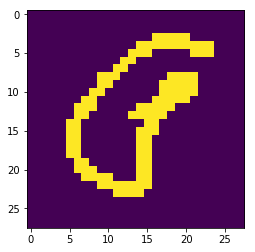

In [6]:
plt.imshow(test_R_2[7][:,:,0])